##################################################
nuHMcode is running
##################################################
Set-up experiment parameters
computing the non-linear total matter power spectrum in the folowing MDM colsmology 

omega_m = 0.14237 
omega_cdm = 0.11677904230191109 
omega_nu = 0.0032209576980888983 
omega_b = 0.02237 
m_ax = 0.3eV 
z = 0.0 
h = 0.674 

--------------------------------------------------
CAMB is running. Computes linear power spectrum for cosmology with massive neutrinos of
CAMB is running. Computes linear power spectrum for a LCDM cosmology
computation time: 47 s
--------------------------------------------------
Calculate massive neutrino quantities:       cut-off mass, neutrino halo mass, clustered fraction.
Create dictionary with parameters of HMCode2020
--------------------------------------------------
Caluclate non-linear power spectrum in mixed DM cosmology with the halo model
Caluclate non-linear power spectrum in LCDM cosmology with the ha

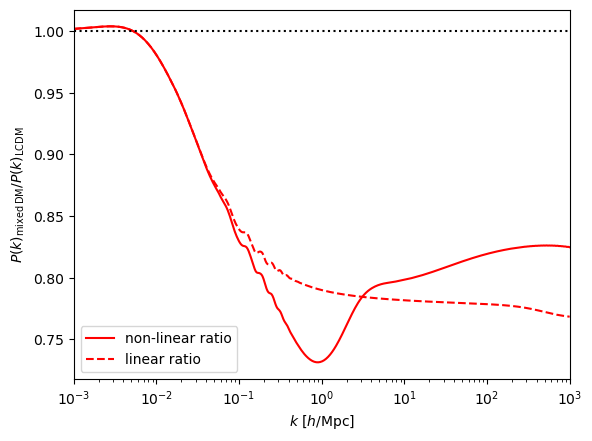

In [1]:
import numpy as np
import time


import matplotlib
from matplotlib import pyplot as plt

import sys
sys.path.append('CAMB_and_lin_PS/')
sys.path.append('cosmology/')
sys.path.append('axion_functions/')
sys.path.append('halo_model/')
sys.path.append('cosmicemu/')

from CAMB_and_lin_PS import CAMB_wrapper 
from CAMB_and_lin_PS import load_cosmology  
from CAMB_and_lin_PS import PS_interpolate 

from halo_model import HMcode_params
from halo_model import PS_nonlin_cold
from halo_model import PS_nonlin_neutrino

from neutrino_functions import neutrino_params


start = time.time()

print('#' * 50)
print('nuHMcode is running')
print('#' * 50)

################################################################################
# Set-up experiment parameters and run axionCAMB
################################################################################
#print('#' * 50)
print('Set-up experiment parameters')
#print('#' * 50)

#IMPORTANT: give the correct path to the intput file which contains all important cosmological parameter
input_file_path = 'input_file.txt'
try:
    f = open(input_file_path)
except IOError:
    print("Input file not accessible, pleas check the file path")
finally:
    f.close()

################################################################################    
# save cosmological parameter in a dictionary 
################################################################################
cosmos = load_cosmology.load_cosmology_input(input_file_path)
cosmos_LCDM = load_cosmology.load_LCDM_cosmology_input(input_file_path)
print("computing the non-linear total matter power spectrum in the folowing MDM colsmology \n")
print("omega_m = {0} \nomega_cdm = {1} \nomega_nu = {2} \nomega_b = {3} \nm_ax = {4}eV \nz = {5} \nh = {6} \n".format(cosmos['omega_m_0'], cosmos['omega_d_0'], cosmos['omega_nu_0'], cosmos['omega_b_0'], 
                                                                                                                          cosmos['mnu'], cosmos['z'], cosmos['h'])) 
 


################################################################################
# Run CAMB on mixed and LCDM cosmology 
################################################################################
print('-' * 50)
#IMPORTANT: you need the python CAMB version to get the linear power spectra
k_arr = np.logspace(-3, np.log10(cosmos['transfer_kmax']),  500)


print("CAMB is running. Computes linear power spectrum for cosmology with massive neutrinos of")
CAMB_wrapper.camb_params('paramfiles/paramfile_CAMB.txt', cosmos) 
#lin PS on given k range
power_spec_dic_nu = CAMB_wrapper.func_power_spec_dic('paramfiles/paramfile_CAMB.txt', cosmos, k_arr)    
#interpolated lin PS for the correct computations of the variance
power_spec_interp_dic_nu = CAMB_wrapper.func_power_spec_interp_dic(power_spec_dic_nu, cosmos)                                                                   
        
print("CAMB is running. Computes linear power spectrum for a LCDM cosmology")                                                                                                                      
CAMB_wrapper.camb_params('paramfiles/paramfile_CAMB_LCDM.txt', cosmos_LCDM) 
#lin PS on given k range
power_spec_dic_LCDM = CAMB_wrapper.func_power_spec_dic('paramfiles/paramfile_CAMB_LCDM.txt', cosmos_LCDM, k_arr)
#interpolated lin PS for the correct computations of the variance
power_spec_interp_dic_LCDM = CAMB_wrapper.func_power_spec_interp_dic(power_spec_dic_LCDM, cosmos_LCDM, LCDM_cosmos=True)


print("computation time: {:.0f} s".format(time.time() -start))

################################################################################
# Compute parameter related to axions and HMCode2020
################################################################################
print('-' * 50)

M_arr = np.logspace(cosmos['M_min'], cosmos['M_max'], 500)

print("Calculate massive neutrino quantities: \
      cut-off mass, neutrino halo mass, clustered fraction.")
neutrinos_params = neutrino_params.func_neutrino_param_dic(M_arr, power_spec_interp_dic_nu['k'], 
                                                           power_spec_interp_dic_nu['cold'], cosmos, 
                                                           LCDM=True)
print("Create dictionary with parameters of HMCode2020")
hmcode_params = HMcode_params.HMCode_param_dic(cosmos, power_spec_interp_dic_nu['k'], 
                                               power_spec_interp_dic_nu['cold'])
hmcode_params_LCDM = HMcode_params.HMCode_param_dic(cosmos_LCDM, power_spec_interp_dic_LCDM['k'], 
                                                    power_spec_interp_dic_LCDM['cold'])



################################################################################
# Caluclate non-linear power spectrum in mixed DM and LCDM cosmology
################################################################################
print('-' * 50)
print('Caluclate non-linear power spectrum in mixed DM cosmology with the halo model')
PS_matter_nonlin = PS_nonlin_neutrino.func_full_halo_model_nu_sophie(M_arr, power_spec_dic_nu['k'], power_spec_dic_nu['cold'], 
                                                                     power_spec_dic_nu['power_nu'], power_spec_interp_dic_nu['k'], 
                                                                     power_spec_interp_dic_nu['cold'], cosmos, hmcode_params, neutrinos_params, 
                                                                     alpha = False, 
                                                                     eta_given = False, 
                                                                     LCDM=True, nu_one_halo=False, 
                                                                     one_halo_damping = True, 
                                                                     two_halo_damping = False)


print('Caluclate non-linear power spectrum in LCDM cosmology with the halo model')
PS_LCDM_matter_nonlin = PS_nonlin_cold.func_non_lin_PS_matter(M_arr, power_spec_dic_LCDM['k'], power_spec_dic_LCDM['power_total'], 
                                                              power_spec_interp_dic_LCDM['k'], power_spec_interp_dic_LCDM['cold'], 
                                                              cosmos_LCDM, hmcode_params_LCDM, cosmos_LCDM['Omega_m_0'], cosmos_LCDM['Omega_db_0'],
                                                              LCDM=True, 
                                                              alpha = False, 
                                                              eta_given = False, 
                                                              nu_one_halo=False, 
                                                              one_halo_damping = True, 
                                                              two_halo_damping = False)

################################################################################
# Save both power stepctra in files
################################################################################
print('-' * 50)
print("Save the non-linear power spectra in a file in the folowing order:")
print("k [h/Mpc], non-lin total matter PS with massive neutrinos [(Mpc/h)^3] and non-lin total matter PS in LCDM [(Mpc/h)^3]")
data_ax = np.column_stack([power_spec_dic_nu['k'], PS_matter_nonlin[0], PS_LCDM_matter_nonlin[0]] )
datafile_path = "nonlin_PS_with_nu.txt" #change path if you want
np.savetxt(datafile_path , data_ax)



print('#' * 50)
print("nuHMcode is finished, total computation time: {:.0f} s".format(time.time() -start))
print('#' * 50)


################################################################################
# Make ratio plot of the two power spectra
################################################################################
plt.semilogx(power_spec_dic_nu['k'], PS_matter_nonlin[0]/PS_LCDM_matter_nonlin[0], label='non-linear ratio', color='r')
plt.semilogx(power_spec_dic_nu['k'], power_spec_dic_nu['power_total']/power_spec_dic_LCDM['power_total'], label='linear ratio', linestyle='--', color='r')
plt.axhline(y = 1, linestyle=':', color='black')
plt.margins(x=0)
plt.legend(loc='lower left')
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P(k)_{\mathrm{mixed\,DM}}/P(k)_{\mathrm{LCDM}}$')
plt.show()

